In [1]:
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm


df = pd.read_csv('labeled_recipes.csv')

def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text


df['ingredients'] = df['ingredients'].apply(clean_text)
df['instructions'] = df['instructions'].apply(clean_text)

df["text"] = df["ingredients"] + " " + df["instructions"]
df["label_encoded"] = df["label"].map({"regular": 0, "fitness": 1})

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label_encoded"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)


class RecipeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = RecipeDataset(train_encodings, list(train_labels))
val_dataset = RecipeDataset(val_encodings, list(val_labels))
test_dataset = RecipeDataset(test_encodings, list(test_labels))


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
model.to(device)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


epochs = 3
progress_bar = tqdm(range(num_training_steps))

train_losses, val_losses, val_accuracies = [], [], []

model.train()
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        progress_bar.update(1)
    train_losses.append(train_loss / len(train_loader))


    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, axis=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += len(batch["labels"])
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss = {train_losses[-1]:.3f}, "
        f"Val Loss = {val_losses[-1]:.3f}, "
        f"Val Accuracy = {val_accuracies[-1]:.3f}"
    )


model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

print("\nClassification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=["regular", "fitness"]))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 6/18 [03:03<04:52, 24.36s/it]

Epoch 1: Train Loss = 0.811, Val Loss = 0.651, Val Accuracy = 0.818


 67%|██████▋   | 12/18 [05:55<02:27, 24.50s/it]

Epoch 2: Train Loss = 0.670, Val Loss = 0.643, Val Accuracy = 0.636


100%|██████████| 18/18 [08:26<00:00, 22.76s/it]

Epoch 3: Train Loss = 0.617, Val Loss = 0.672, Val Accuracy = 0.545

Classification Report on Test Set:
              precision    recall  f1-score   support

     regular       1.00      0.43      0.60         7
     fitness       0.56      1.00      0.71         5

    accuracy                           0.67        12
   macro avg       0.78      0.71      0.66        12
weighted avg       0.81      0.67      0.65        12



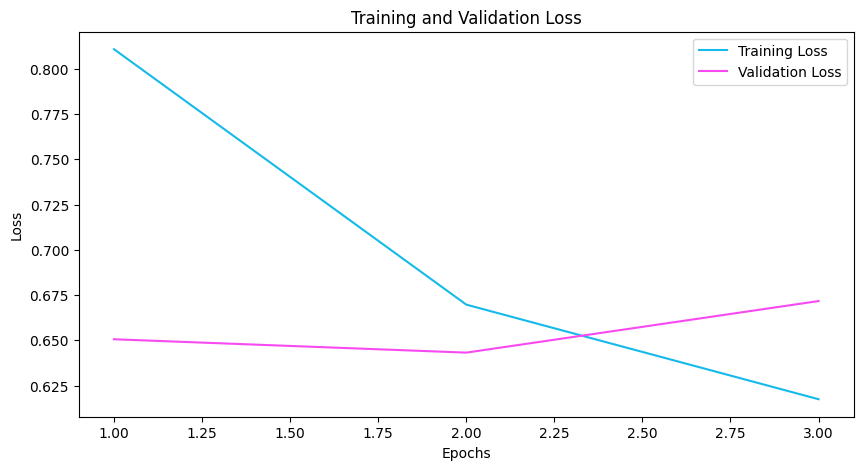

In [2]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", color="#14baea")
plt.plot(epochs_range, val_losses, label="Validation Loss", color="#f84af0")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

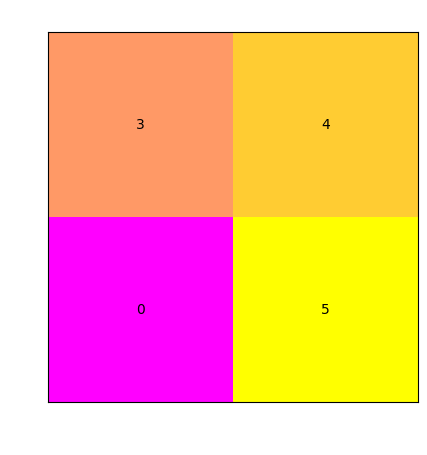

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predictions)


fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='spring', ax=ax, colorbar=False)


fig.patch.set_alpha(0)
ax.patch.set_alpha(0)


for text in ax.texts:
    text.set_color("black")


plt.title('Confusion Matrix', color='white')

ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.tick_params(colors="white")

plt.show()